In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB

from sklearn.feature_selection import SelectKBest, f_classif
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt

In [4]:
# Load the dataset
data = pd.read_csv('/Users/suchithkurra/Desktop/Honey_Pot Research/data/Web_attack.csv')

In [5]:
# Data preprocessing
# Drop any rows with missing values
data.dropna(inplace=True)

In [6]:
# Replace infinite or very large values with NaN
data.replace([np.inf, -np.inf], np.nan, inplace=True)

In [7]:
# Drop rows containing NaN values
data.dropna(inplace=True)

In [8]:
from sklearn.preprocessing import LabelEncoder

# Encode target variable
label_encoder = LabelEncoder()
data['Label'] = label_encoder.fit_transform(data['Label'])

In [9]:
# Split features and target variable
X = data.drop('Label', axis=1)
y = data['Label']

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [11]:
# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [12]:
# SelectKBest with ANOVA F-value
k = 20  # Number of top features to select
selector = SelectKBest(score_func=f_classif, k=k)
X_train_selected = selector.fit_transform(X_train_scaled, y_train)
X_test_selected = selector.transform(X_test_scaled)

In [13]:
selected_features_indices = selector.get_support(indices=True)

In [14]:
selected_feature_names = X.columns[selected_features_indices]

In [15]:
# Print the selected feature names
print("Selected features:")
print(selected_feature_names)

Selected features:
Index(['Destination Port', 'Fwd Packet Length Min', 'Fwd Packet Length Mean',
       'Bwd Packet Length Max', 'Bwd Packet Length Min',
       'Bwd Packet Length Mean', 'Fwd IAT Std', 'Min Packet Length',
       'Max Packet Length', 'Packet Length Mean', 'Packet Length Std',
       'PSH Flag Count', 'ACK Flag Count', 'Down/Up Ratio',
       'Average Packet Size', ' Avg Fwd Segment Size', 'Avg Bwd Segment Size',
       'Init_Win_bytes_forward', 'Init_Win_bytes_backward',
       'min_seg_size_forward'],
      dtype='object')


In [16]:
# Train Logistic Regression classifier
logistic_regression_classifier = LogisticRegression(max_iter=1000)
logistic_regression_classifier.fit(X_train_selected, y_train)


LogisticRegression(max_iter=1000)

In [17]:
# Predict probabilities on the test set
y_score = logistic_regression_classifier.predict_proba(X_test_selected)

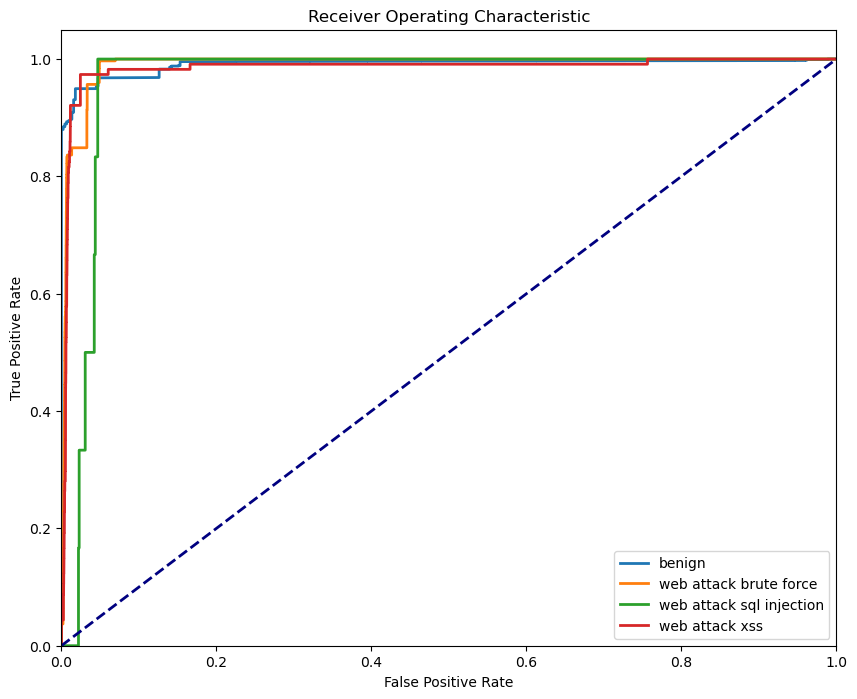

In [26]:
# Define class names
class_names = ['benign', 'web attack brute force', 'web attack sql injection', 'web attack xss']

# Compute ROC curve for each class
plt.figure(figsize=(10, 8))
for i in range(len(logistic_regression_classifier.classes_)):
    fpr, tpr, _ = roc_curve(y_test == logistic_regression_classifier.classes_[i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=class_names[i])

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

Overall Model Metrics:
  Accuracy: 0.9855200164478515
  Precision: 0.97828615953493
  F1-Score: 0.980566803570507


/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


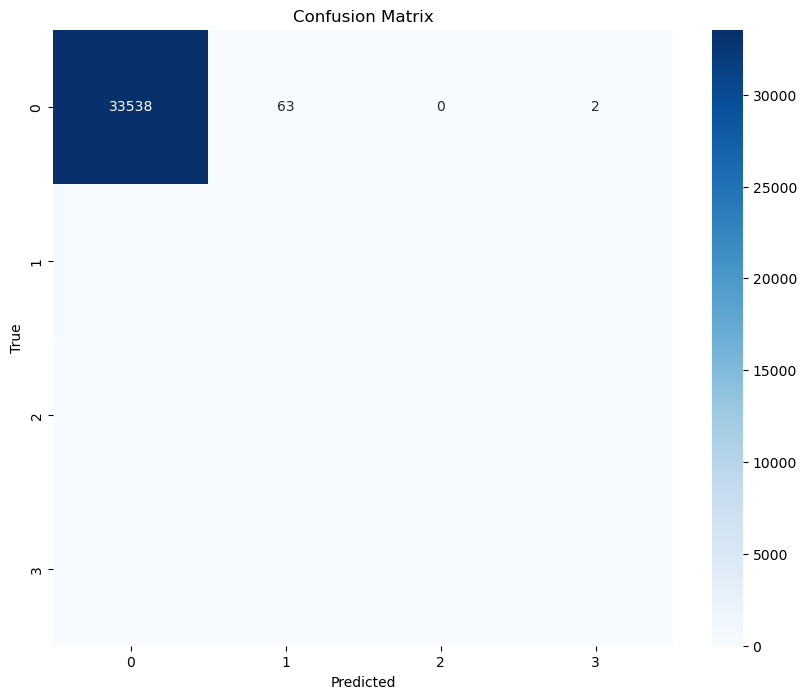

In [34]:
from sklearn.metrics import accuracy_score, precision_score, f1_score
import seaborn as sns


# Calculate accuracy, precision, and F1-score for each class
y_pred = logistic_regression_classifier.predict(X_test_selected)
# Calculate accuracy, precision, and F1-score for the overall model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Print accuracy, precision, and F1-score for the overall model
print("Overall Model Metrics:")
print(f"  Accuracy: {accuracy}")
print(f"  Precision: {precision}")
print(f"  F1-Score: {f1:}")
print()

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [30]:
# Extracting false positives and false negatives from confusion matrix
FP = conf_matrix[0, 1]  # False positives: predicted DDoS, actual BENIGN
FN = conf_matrix[1, 0]  # False negatives: predicted BENIGN, actual DDoS

print("False Positives:", FP)
print("False Negatives:", FN)

False Positives: 63
False Negatives: 312


In [31]:
# Number of test values
num_test_values = len(y_test)
print("Number of test values:", num_test_values)

Number of test values: 34047


In [32]:
# Calculate percentage of false positives and false negatives
percentage = ((FP + FN) / num_test_values) * 100

print("Percentage of False Positives and False Negatives: {:.2f}%".format(percentage))

Percentage of False Positives and False Negatives: 1.10%


In [33]:
import joblib

# Save the trained model to a file
joblib.dump(logistic_regression_classifier, 'web_attack_logisticreg.pkl')

['web_attack_logisticreg.pkl']